In [2163]:
import cv2 as cv
import io
import matplotlib.pyplot as plt
from skimage.exposure import  equalize_hist
from skimage.morphology import dilation, erosion, area_closing, area_opening
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
import joblib

import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
from PIL import Image

In [2281]:
im=cv.imread('Desktop/trainw7.jpg')

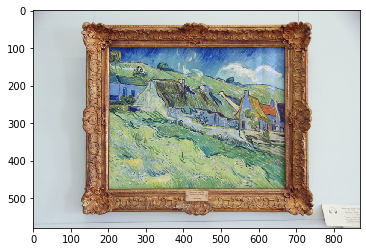

In [2282]:
implt= cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(implt)

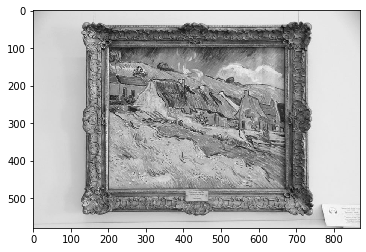

In [2283]:
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')
blur = cv.blur(gray,(5,5))
threshad = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, 
                                      cv.THRESH_BINARY, 199, 5) 
outer=cv.bitwise_not(threshad,threshad)
outer_erode= erosion(outer)
areaArray = []
count = 0
ids=[]
contours, _ = cv.findContours(outer_erode, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv.contourArea(c)
    areaArray.append(area)
    if(area>gray.shape[1]*100): #3,33: #100000 #train3333: 500000 #*100
        ids.append(i)
        count+=1    #number of detected contours

In [2284]:
count

2

In [2285]:
mi=1e10
ids=np.array(ids)
if(len(ids)>1):
    for i in ids:
        if areaArray[i]<mi:
            mi=areaArray[i]
            res=i
else:
    res=ids[0]

In [2286]:
max(areaArray)

295468.0

In [2287]:
for i in ids:
    print('area:',i)
    print(areaArray[i])

area: 5
295468.0
area: 102
156397.5


In [2288]:
res

102

In [2289]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates (tr,tl,br,bl)
    return rect

In [2290]:
def four_point_transform(image, points):
    rect = order_points(points)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))


    dst = np.array([[0, 0],
    [0, maxWidth - 1],
    [ maxHeight - 1,maxWidth - 1],
    [ maxHeight - 1,0]], dtype = "float32")

    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxHeight,maxWidth))
    return warped

In [2291]:
# ids=np.array(ids)
# flag=1   #this flag is used to point that only one painting detected,
# if(len(ids)==1):  #it is unset if more than one painting were detected so it needs filering
#     flag=0
# sud_count=0
out= np.zeros((gray.shape[0],gray.shape[1]))
# for cnt_id in ids:
perimeter = cv.arcLength(contours[res], True)
epsilon = 0.04* perimeter #0.04
approx = cv.approxPolyDP(contours[res],epsilon,True)
app=approx[:,0][:]
perimeter = cv.arcLength(contours[res], True)
points=app
warp= four_point_transform(implt, points)
# if(abs(warp.shape[0]-warp.shape[1]) >400) & flag:    #param can be adjusted
#     continue
warped=warp.copy()
h=warped.shape[0]
w=warped.shape[1]
warped = cv.transpose(warped)

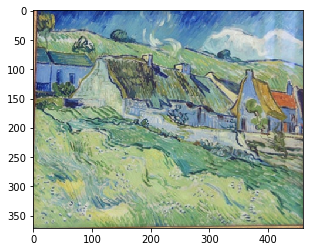

In [2292]:
plt.imshow(warped)

In [2301]:
def inverse_transform(img_warped,original, points):
    rect = order_points(points)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))


    dst = np.array([[0, 0],
    [0, maxWidth - 1],
    [ maxHeight - 1,maxWidth - 1],
    [ maxHeight - 1,0]], dtype = "float32")

    M = cv.getPerspectiveTransform(dst, rect)
    result = cv.warpPerspective(img_warped, M, (original.shape[1],original.shape[0]))
    return result

In [2302]:
fin=inverse_transform(cv.transpose(warped),im,points)

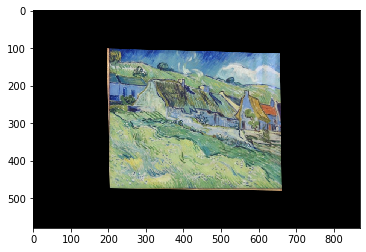

In [2303]:
plt.imshow(fin)

In [2304]:
img=implt.copy()

In [2305]:
img[fin>0]=fin[fin>0]

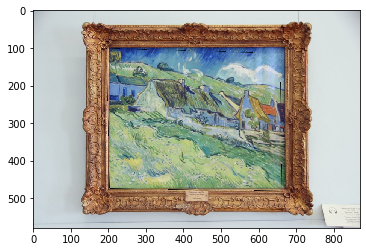

In [2306]:
plt.imshow(img)